<a target="_blank" href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL-Tutorials/blob/master/1-Introduction/Stock_NeurIPS2018_SB3.py">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading

* **Pytorch Version**



# Content

* [1. Task Description](#0)
* [2. Install Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. A List of Python Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download and Preprocess Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5. Build Market Environment in OpenAI Gym-style](#4)  
    * [5.1. Data Split](#4.1)  
    * [5.3. Environment for Training](#4.2)    
* [6. Train DRL Agents](#5)
* [7. Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
  

<a id='0'></a>
# Part 1. Task Discription

We train a DRL agent for stock trading. This task is modeled as a Markov Decision Process (MDP), and the objective function is maximizing (expected) cumulative return.

We specify the state-action-reward as follows:

* **State s**: The state space represents an agent's perception of the market environment. Just like a human trader analyzing various information, here our agent passively observes many features and learns by interacting with the market environment (usually by replaying historical data).

* **Action a**: The action space includes allowed actions that an agent can take at each state. For example, a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying. When an action operates multiple shares, a ∈{−k, ..., −1, 0, 1, ..., k}, e.g.. "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* **Reward function r(s, a, s′)**: Reward is an incentive for an agent to learn a better policy. For example, it can be the change of the portfolio value when taking a at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio values at state s′ and s, respectively


**Market environment**: 30 consituent stocks of Dow Jones Industrial Average (DJIA) index. Accessed at the starting date of the testing period.


The data for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Install Python Packages

<a id='1.1'></a>
## 2.1. Install packages


In [ ]:
## install required packages
!pip install swig
!pip install wrds
!pip install pyportfolioopt
## install finrl library
!pip install -q condacolab
import condacolab
condacolab.install()
!apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

✨🍰✨ Everything looks OK!
  Cloning https://github.com/AI4Finance-Foundation/FinRL.git to /tmp/pip-req-build-xv4uvmgz
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/FinRL.git /tmp/pip-req-build-xv4uvmgz
  Resolved https://github.com/AI4Finance-Foundation/FinRL.git to commit e92b6bbe4e5300afb29fb36fc36dc0ca72dca331
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /tmp/pip-install-p8k2n3wo/elegantrl_90be0207d1ef481c97c5617e12a4badb
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/ElegantRL.git /tmp/pip-install-p8k2n3wo/elegantrl_90be0207d1ef481c97c5617e12a4badb
  Resolved https://github.com/AI4Finance-Foundation/ElegantRL.git to commit 155f07fcfe2d0f0a0318f820e8e2f2401ff30eca
  Preparing metadata (setup.py) ... done



<a id='1.2'></a>
## 2.2. A list of Python packages
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
#from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3.common.logger import configure
from finrl.meta.data_processor import DataProcessor

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

import sys
sys.path.append("../FinRL")

import itertools

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

<a id='1.4'></a>
## 2.4. Create Folders

In [ ]:
from finrl import config
from finrl import config_tickers
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)
check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])



<a id='2'></a>
# Part 3. Download Data
Yahoo Finance provides stock data, financial news, financial reports, etc. Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** in FinRL-Meta to fetch data via Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).



-----
class YahooDownloader:
    Retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()


In [ ]:
# from config.py, TRAIN_START_DATE is a string
TRAIN_START_DATE
# from config.py, TRAIN_END_DATE is a string
TRAIN_END_DATE

'2020-07-31'

In [ ]:
TRAIN_START_DATE = '2019-01-01'
TRAIN_END_DATE = '2020-01-01'
TRADE_START_DATE = '2020-01-01'
TRADE_END_DATE = '2023-02-20'

In [ ]:
# top 50 market cap tickers
major_tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'BRK.B', 'TSLA', 'NVDA', 'GOOG', 'UNH', 'XOM', 'JNJ', 'JPM', 'META', 'V', 'PG', 'HD', 'MA', 'CVX', 'MRK', 'ABBV', 'LLY', 'PEP', 'BAC', 'PFE', 'KO', 'AVGO', 'COST', 'TMO', 'WMT', 'CSCO', 'MCD', 'DIS', 'ABT', 'WFC', 'ACN', 'VZ', 'CMCSA', 'DHR', 'CRM', 'LIN', 'ADBE', 'TXN', 'PM', 'BMY', 'NKE', 'NFLX', 'RTX', 'NEE', 'QCOM', 'T']

df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = major_tickers).fetch_data()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['BRK.B']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[***

Shape of DataFrame:  (51009, 8)


In [ ]:
ticker_list = major_tickers

In [ ]:
print(config_tickers.DOW_30_TICKER)
len(config_tickers.DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


30

In [ ]:
ticker_list=df["tic"].unique().tolist()
ticker_list

['AAPL',
 'ABBV',
 'ABT',
 'ACN',
 'ADBE',
 'AMZN',
 'AVGO',
 'BAC',
 'BMY',
 'CMCSA',
 'COST',
 'CRM',
 'CSCO',
 'CVX',
 'DHR',
 'DIS',
 'GOOG',
 'GOOGL',
 'HD',
 'JNJ',
 'JPM',
 'KO',
 'LIN',
 'LLY',
 'MA',
 'MCD',
 'META',
 'MRK',
 'MSFT',
 'NEE',
 'NFLX',
 'NKE',
 'NVDA',
 'PEP',
 'PFE',
 'PG',
 'PM',
 'QCOM',
 'RTX',
 'T',
 'TMO',
 'TSLA',
 'TXN',
 'UNH',
 'V',
 'VZ',
 'WFC',
 'WMT',
 'XOM']

In [ ]:
df.sort_values(['date','tic'],ignore_index=True).head()

,date,open,high,low,close,volume,tic,day
0,2019-01-02,38.722500,39.712502,38.557499,37.793781,148158800,AAPL,2
1,2019-01-02,91.239998,91.260002,88.419998,69.330460,6908400,ABBV,2
2,2019-01-02,70.389999,70.959999,69.070000,63.287052,8737200,ABT,2
3,2019-01-02,138.929993,141.190002,138.279999,130.096817,2059300,ACN,2
4,2019-01-02,219.910004,226.169998,219.000000,224.570007,2784100,ADBE,2


# Part 4: Preprocess Data
We need to check for missing data and do feature engineering to convert the data point into a state.
* **Adding technical indicators**. In practical trading, various information needs to be taken into account, such as historical prices, current holding shares, technical indicators, etc. Here, we demonstrate two trend-following technical indicators: MACD and RSI.
* **Adding turbulence index**. Risk-aversion reflects whether an investor prefers to protect the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the turbulence index that measures extreme fluctuation of asset price.

In [ ]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = INDICATORS,
                    use_vix=True,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

Successfully added technical indicators


[*********************100%%**********************]  1 of 1 completed


Shape of DataFrame:  (1040, 8)
Successfully added vix
Successfully added turbulence index


In [ ]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)
processed['date'].min()


'2019-01-02'

In [ ]:
processed_full_pivot = processed_full.pivot(index='date', columns='tic', values='close')

# 选择你需要的两支股票，例如 'AAPL' 和 'AMGN'
df_kelly = processed_full_pivot[ticker_list]

# 重置索引，方便查看结果
df_kelly = df_kelly.reset_index()

# 显示结果
print(df_kelly)


tic         date        AAPL        ABBV         ABT         ACN        ADBE  \
0     2019-01-02   37.793781   69.330460   63.287052  130.096817  224.570007   
1     2019-01-03   34.029247   67.046135   60.300282  125.655067  215.699997   
2     2019-01-04   35.481922   69.206169   62.021305  130.541016  226.190002   
3     2019-01-07   35.402939   70.216225   62.950127  130.994446  229.259995   
4     2019-01-08   36.077839   70.542557   62.194332  134.307236  232.679993   
...          ...         ...         ...         ...         ...         ...   
1035  2023-02-10  150.004776  144.786865  105.483566  278.562622  370.989990   
1036  2023-02-13  152.825882  146.386597  105.834656  282.869232  375.000000   
1037  2023-02-14  152.180191  145.301041  104.605835  279.357269  377.899994   
1038  2023-02-15  154.296021  143.844131  104.625336  282.182495  375.940002   
1039  2023-02-16  152.686813  142.387222  103.455040  275.874786  365.160004   

tic         AMZN        AVGO        BAC

In [ ]:
## This is for implmenting classical Kelly
## here R = S_t/S_t-1
## This is for implmenting classical Kelly
## here R = S_t/S_t-1
def kelly2(logR,J,n):
  w = cp.Variable(n)
  R = np.exp(logR)       # convert the input logR to R:=S_t/S_t-1

  ## introduce a risk-free rate asset, with interest 0
  w0 = cp.Variable(1)

#  obj = 0
#  for sample in range(J):
#      obj += cp.log(R[sample]@w)

  obj = sum(cp.log(R@w))

  maxi = cp.Maximize(obj)

  subj_to = [w0+cp.sum(w) == 1.0, w >= 0, w0>=0]

  prob = cp.Problem(maxi, subj_to)
  prob.solve(solver=cp.MOSEK, verbose=False)

  #plt.bar(range(len(w.value)), w.value)
  #plt.show()
  #print(sum(w.value))

  return w.value


In [ ]:
## This is for implementing Wasserstein-Kelly
## Here, R is \ln(S_t/S_t-1) = \lnS_t - \lnS_t-1, which is different from the R in the Kelly
def wass_kelly2(R,J,n,eps):
  p=2
  q=2

  V = cp.Variable((J, n))
  w = cp.Variable(n)
  lamba = cp.Variable()

  dum = np.zeros((J, n))
  dum2 = np.zeros(J)
  ## introduce a risk-free rate asset, with interest 0
  w0 = cp.Variable(1)

  obj = 0
  dum = []
  dum2 = []
  for sample in range(J):

      for i in range(n):
            dum.append(cp.rel_entr(V[sample, i], w[i]))
      dum2.append((1 / (q * (p ** (q - 1)))) * cp.quad_over_lin(V[sample], lamba))

  obj = cp.sum(dum) - cp.sum(cp.multiply(R,V)) + cp.sum(dum2)

  ## Let eps = average size of log return * a percentage (eps)
  # Calculate the average of all entries
  average_log_returns = np.mean(np.abs(R))
  eps = eps * average_log_returns

  obj = (1 / J) * obj + lamba * (eps ** p)
  mini = cp.Minimize(obj)

  subj_to = [
     lamba >= 0,
      w0+cp.sum(w) == 1.0,
      w >= 0,
      V >=0,
      w0 >=0
  ]

  prob = cp.Problem(mini, subj_to)
  prob.solve(solver=cp.MOSEK, verbose=False)

  return w.value

In [ ]:
!pip install Mosek
!pip install yfinance
!pip install cvxpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 43.7 MB/s eta 0:00:00


In [ ]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import random
from math import trunc

In [ ]:
# Number of times to sample 5 assets
num_samples = 1000

# Number of assets to sample each time
num_assets = 10

# Create an empty array to store the samples
days = df_kelly.shape[0]
S = np.zeros((num_samples, days, num_assets))

# Loop over the number of samples and randomly select 5 assets each time
num_sampling = 0

while num_sampling < num_samples:

    # Randomly select 5 assets from the tickers list
    selected_tickers = random.sample(ticker_list, num_assets)

    # Get the data for the selected tickers
    sample_data = df_kelly[selected_tickers]

    if not np.isnan(sample_data.to_numpy()).any():

        # Store the data in the S array
        S[num_sampling,:,:] = sample_data.to_numpy()
        #fig, ax = plt.subplots()
        # Loop over the number of assets in each sample and plot their time series
        #for j in range(num_assets):
        #    asset_data = S[num_sampling,:,j]
        #    ax.plot(asset_data, label=selected_tickers[j])

        # Set the title, legend, and axis labels for the subplot
        #ax.set_title("Sample {}".format(num_sampling+1))
        #ax.legend()
        #ax.set_xlabel("Time")
        #ax.set_ylabel("Asset Price")

        # Show the plot for the current sample
        #plt.show()

        num_sampling = num_sampling + 1


In [ ]:
df_kelly[df_kelly['date'] == '2020-01-02'][ticker_list]

tic,AAPL,ABBV,ABT,ACN,ADBE,AMZN,AVGO,BAC,BMY,CMCSA,...,T,TMO,TSLA,TXN,UNH,V,VZ,WFC,WMT,XOM
252,72.960472,73.511116,80.490295,196.918213,334.429993,94.900497,282.428558,32.048058,54.887218,40.680515,...,20.629431,323.139648,28.684,114.222321,274.94635,185.20871,47.827457,47.685783,36.969147,56.539856


In [ ]:
processed_full.sort_values(['date','tic'],ignore_index=True).head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2019-01-02,AAPL,38.722500,39.712502,38.557499,37.793781,148158800.0,2.0,0.0,41.235369,30.587659,0.0,-66.666667,100.0,37.793781,37.793781,23.219999,0.0
1,2019-01-02,ABBV,91.239998,91.260002,88.419998,69.330460,6908400.0,2.0,0.0,41.235369,30.587659,0.0,-66.666667,100.0,69.330460,69.330460,23.219999,0.0
2,2019-01-02,ABT,70.389999,70.959999,69.070000,63.287052,8737200.0,2.0,0.0,41.235369,30.587659,0.0,-66.666667,100.0,63.287052,63.287052,23.219999,0.0
3,2019-01-02,ACN,138.929993,141.190002,138.279999,130.096817,2059300.0,2.0,0.0,41.235369,30.587659,0.0,-66.666667,100.0,130.096817,130.096817,23.219999,0.0
4,2019-01-02,ADBE,219.910004,226.169998,219.000000,224.570007,2784100.0,2.0,0.0,41.235369,30.587659,0.0,-66.666667,100.0,224.570007,224.570007,23.219999,0.0


In [ ]:
mvo_df = processed_full.sort_values(['date','tic'],ignore_index=True)[['date','tic','close']]

<a id='4'></a>
# Part 5. Build A Market Environment in OpenAI Gym-style
The training process involves observing stock price change, taking an action and reward's calculation. By interacting with the market environment, the agent will eventually derive a trading strategy that may maximize (expected) rewards.

Our market environment, based on OpenAI Gym, simulates stock markets with historical market data.

## Data Split
We split the data into training set and testing set as follows:

Training data period: 2009-01-01 to 2020-07-01

Trading data period: 2020-07-01 to 2021-10-31


In [ ]:
train = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE)
print(len(train))
print(len(trade))
TRADE_START_DATE

12348
38612


'2020-01-01'

In [ ]:
train.tail()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
251,2019-12-31,V,187.059998,188.000000,186.539993,182.088318,5273000.0,1.0,2.011053,184.804061,173.912842,58.620165,96.595919,12.589650,178.286333,174.910865,13.78,0.0
251,2019-12-31,VZ,61.209999,61.400002,60.939999,48.101665,8466700.0,1.0,0.256966,48.524324,47.251258,56.220317,58.585682,8.866467,47.524286,47.285012,13.78,0.0
251,2019-12-31,WFC,53.529999,53.820000,53.459999,47.730141,12566000.0,1.0,0.168280,48.484806,46.854811,55.678621,-32.258633,9.626879,47.744627,46.513862,13.78,0.0
251,2019-12-31,WMT,39.833332,39.933334,39.396667,36.938072,14736000.0,1.0,0.045243,37.631097,36.662473,51.365022,-65.561912,0.489229,37.077207,36.955646,13.78,0.0
251,2019-12-31,XOM,69.019997,69.800003,69.010002,55.646709,13151800.0,1.0,0.187631,56.463194,54.397197,51.173132,30.174501,10.358003,55.196937,54.928986,13.78,0.0


In [ ]:
trade.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2020-01-02,AAPL,74.059998,75.150002,73.797501,72.960472,135480400.0,3.0,2.124958,72.881519,62.758625,76.475240,176.804962,58.795790,66.611474,63.300513,12.47,0.0
0,2020-01-02,ABBV,89.080002,89.570000,88.510002,73.511116,5639200.0,3.0,0.869826,74.768653,70.514080,62.571959,60.950694,33.770869,72.324090,68.836790,12.47,0.0
0,2020-01-02,ABT,86.059998,86.959999,85.800003,80.490295,4969000.0,3.0,0.678277,81.850731,77.915332,56.843418,53.939627,5.840770,79.337173,77.771634,12.47,0.0
0,2020-01-02,ACN,210.860001,211.919998,208.809998,196.918213,2431100.0,3.0,3.549217,201.737180,185.296360,64.360388,98.792992,37.063899,191.152939,183.386945,12.47,0.0
0,2020-01-02,ADBE,330.000000,334.480011,329.170013,334.429993,1990100.0,3.0,8.903298,342.941103,296.064899,69.757664,109.325637,45.346736,314.243000,296.655334,12.47,0.0


In [ ]:
INDICATORS

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [ ]:
stock_dimension = 49
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 49, State Space: 491


In [ ]:
from __future__ import annotations

from typing import List

import gymnasium as gym
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from gymnasium import spaces
from gymnasium.utils import seeding
from stable_baselines3.common.vec_env import DummyVecEnv

matplotlib.use("Agg")

# from stable_baselines3.common.logger import Logger, KVWriter, CSVOutputFormat


class StockTradingEnv(gym.Env):
    """A stock trading environment for OpenAI gym"""

    metadata = {"render.modes": ["human"]}

    def __init__(
        self,
        df: pd.DataFrame,
        stock_dim: int,
        hmax: int,
        initial_amount: int,
        num_stock_shares: list[int],
        buy_cost_pct: list[float],
        sell_cost_pct: list[float],
        reward_scaling: float,
        state_space: int,
        action_space: int,
        tech_indicator_list: list[str],
        turbulence_threshold=None,
        risk_indicator_col="turbulence",
        make_plots: bool = False,
        print_verbosity=10,
        day=0,
        initial=True,
        previous_state=[],
        model_name="",
        mode="",
        iteration="",
    ):
        self.day = day
        self.df = df
        self.stock_dim = stock_dim
        self.hmax = hmax
        self.num_stock_shares = num_stock_shares
        self.initial_amount = initial_amount  # get the initial cash
        self.buy_cost_pct = buy_cost_pct
        self.sell_cost_pct = sell_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list
        self.action_space = spaces.Box(low=-1, high=1, shape=(self.action_space,))
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(self.state_space,)
        )
        self.data = self.df.loc[self.day, :]
        self.terminal = False
        self.make_plots = make_plots
        self.print_verbosity = print_verbosity
        self.turbulence_threshold = turbulence_threshold
        self.risk_indicator_col = risk_indicator_col
        self.initial = initial
        self.previous_state = previous_state
        self.model_name = model_name
        self.mode = mode
        self.iteration = iteration
        # initalize state
        self.state = self._initiate_state()

        # initialize reward
        self.reward = 0
        self.turbulence = 0
        self.cost = 0
        self.trades = 0
        self.episode = 0
        # memorize all the total balance change
        self.asset_memory = [
            self.initial_amount
            + np.sum(
                np.array(self.num_stock_shares)
                * np.array(self.state[1 : 1 + self.stock_dim])
            )
        ]  # the initial total asset is calculated by cash + sum (num_share_stock_i * price_stock_i)
        self.rewards_memory = []
        self.actions_memory = []
        self.state_memory = (
            []
        )  # we need sometimes to preserve the state in the middle of trading process
        self.date_memory = [self._get_date()]
        #         self.logger = Logger('results',[CSVOutputFormat])
        # self.reset()
        self._seed()

    def _sell_stock(self, index, action):
        def _do_sell_normal():
            if (
                self.state[index + 2 * self.stock_dim + 1] != True
            ):  # check if the stock is able to sell, for simlicity we just add it in techical index
                # if self.state[index + 1] > 0: # if we use price<0 to denote a stock is unable to trade in that day, the total asset calculation may be wrong for the price is unreasonable
                # Sell only if the price is > 0 (no missing data in this particular date)
                # perform sell action based on the sign of the action
                if self.state[index + self.stock_dim + 1] > 0:
                    # Sell only if current asset is > 0
                    sell_num_shares = min(
                        abs(action), self.state[index + self.stock_dim + 1]
                    )
                    sell_amount = (
                        self.state[index + 1]
                        * sell_num_shares
                        * (1 - self.sell_cost_pct[index])
                    )
                    # update balance
                    self.state[0] += sell_amount

                    self.state[index + self.stock_dim + 1] -= sell_num_shares
                    self.cost += (
                        self.state[index + 1]
                        * sell_num_shares
                        * self.sell_cost_pct[index]
                    )
                    self.trades += 1
                else:
                    sell_num_shares = 0
            else:
                sell_num_shares = 0

            return sell_num_shares

        # perform sell action based on the sign of the action
        if self.turbulence_threshold is not None:
            if self.turbulence >= self.turbulence_threshold:
                if self.state[index + 1] > 0:
                    # Sell only if the price is > 0 (no missing data in this particular date)
                    # if turbulence goes over threshold, just clear out all positions
                    if self.state[index + self.stock_dim + 1] > 0:
                        # Sell only if current asset is > 0
                        sell_num_shares = self.state[index + self.stock_dim + 1]
                        sell_amount = (
                            self.state[index + 1]
                            * sell_num_shares
                            * (1 - self.sell_cost_pct[index])
                        )
                        # update balance
                        self.state[0] += sell_amount
                        self.state[index + self.stock_dim + 1] = 0
                        self.cost += (
                            self.state[index + 1]
                            * sell_num_shares
                            * self.sell_cost_pct[index]
                        )
                        self.trades += 1
                    else:
                        sell_num_shares = 0
                else:
                    sell_num_shares = 0
            else:
                sell_num_shares = _do_sell_normal()
        else:
            sell_num_shares = _do_sell_normal()

        return sell_num_shares

    def _buy_stock(self, index, action):
        def _do_buy():
            if (
                self.state[index + 2 * self.stock_dim + 1] != True
            ):  # check if the stock is able to buy
                # if self.state[index + 1] >0:
                # Buy only if the price is > 0 (no missing data in this particular date)
                available_amount = self.state[0] // (
                    self.state[index + 1] * (1 + self.buy_cost_pct[index])
                )  # when buying stocks, we should consider the cost of trading when calculating available_amount, or we may be have cash<0
                # print('available_amount:{}'.format(available_amount))

                # update balance
                buy_num_shares = min(available_amount, action)
                buy_amount = (
                    self.state[index + 1]
                    * buy_num_shares
                    * (1 + self.buy_cost_pct[index])
                )
                self.state[0] -= buy_amount

                self.state[index + self.stock_dim + 1] += buy_num_shares

                self.cost += (
                    self.state[index + 1] * buy_num_shares * self.buy_cost_pct[index]
                )
                self.trades += 1
            else:
                buy_num_shares = 0

            return buy_num_shares

        # perform buy action based on the sign of the action
        if self.turbulence_threshold is None:
            buy_num_shares = _do_buy()
        else:
            if self.turbulence < self.turbulence_threshold:
                buy_num_shares = _do_buy()
            else:
                buy_num_shares = 0
                pass

        return buy_num_shares

    def _make_plot(self):
        plt.plot(self.asset_memory, "r")
        plt.savefig(f"results/account_value_trade_{self.episode}.png")
        plt.close()

    def step(self, actions):
        self.terminal = self.day >= len(self.df.index.unique()) - 1
        if self.terminal:
            # print(f"Episode: {self.episode}")
            if self.make_plots:
                self._make_plot()
            end_total_asset = self.state[0] + sum(
                np.array(self.state[1 : (self.stock_dim + 1)])
                * np.array(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
            )
            df_total_value = pd.DataFrame(self.asset_memory)
            tot_reward = (
                self.state[0]
                + sum(
                    np.array(self.state[1 : (self.stock_dim + 1)])
                    * np.array(
                        self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)]
                    )
                )
                - self.asset_memory[0]
            )  # initial_amount is only cash part of our initial asset
            df_total_value.columns = ["account_value"]
            df_total_value["date"] = self.date_memory
            df_total_value["daily_return"] = df_total_value["account_value"].pct_change(
                1
            )
            if df_total_value["daily_return"].std() != 0:
                sharpe = (
                    (252**0.5)
                    * df_total_value["daily_return"].mean()
                    / df_total_value["daily_return"].std()
                )
            df_rewards = pd.DataFrame(self.rewards_memory)
            df_rewards.columns = ["account_rewards"]
            df_rewards["date"] = self.date_memory[:-1]
            if self.episode % self.print_verbosity == 0:
                print(f"day: {self.day}, episode: {self.episode}")
                print(f"begin_total_asset: {self.asset_memory[0]:0.2f}")
                print(f"end_total_asset: {end_total_asset:0.2f}")
                print(f"total_reward: {tot_reward:0.2f}")
                print(f"total_cost: {self.cost:0.2f}")
                print(f"total_trades: {self.trades}")
                if df_total_value["daily_return"].std() != 0:
                    print(f"Sharpe: {sharpe:0.3f}")
                print("=================================")

            if (self.model_name != "") and (self.mode != ""):
                df_actions = self.save_action_memory()
                df_actions.to_csv(
                    "results/actions_{}_{}_{}.csv".format(
                        self.mode, self.model_name, self.iteration
                    )
                )
                df_total_value.to_csv(
                    "results/account_value_{}_{}_{}.csv".format(
                        self.mode, self.model_name, self.iteration
                    ),
                    index=False,
                )
                df_rewards.to_csv(
                    "results/account_rewards_{}_{}_{}.csv".format(
                        self.mode, self.model_name, self.iteration
                    ),
                    index=False,
                )
                plt.plot(self.asset_memory, "r")
                plt.savefig(
                    "results/account_value_{}_{}_{}.png".format(
                        self.mode, self.model_name, self.iteration
                    )
                )
                plt.close()

            # Add outputs to logger interface
            # logger.record("environment/portfolio_value", end_total_asset)
            # logger.record("environment/total_reward", tot_reward)
            # logger.record("environment/total_reward_pct", (tot_reward / (end_total_asset - tot_reward)) * 100)
            # logger.record("environment/total_cost", self.cost)
            # logger.record("environment/total_trades", self.trades)

            return self.state, self.reward, self.terminal, False, {}

        else:
            actions = actions * self.hmax  # actions initially is scaled between 0 to 1
            actions = actions.astype(
                int
            )  # convert into integer because we can't by fraction of shares
            if self.turbulence_threshold is not None:
                if self.turbulence >= self.turbulence_threshold:
                    actions = np.array([-self.hmax] * self.stock_dim)
            begin_total_asset = self.state[0] + sum(
                np.array(self.state[1 : (self.stock_dim + 1)])
                * np.array(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
            )
            # print("begin_total_asset:{}".format(begin_total_asset))

            argsort_actions = np.argsort(actions)
            sell_index = argsort_actions[: np.where(actions < 0)[0].shape[0]]
            buy_index = argsort_actions[::-1][: np.where(actions > 0)[0].shape[0]]

            for index in sell_index:
                # print(f"Num shares before: {self.state[index+self.stock_dim+1]}")
                # print(f'take sell action before : {actions[index]}')
                actions[index] = self._sell_stock(index, actions[index]) * (-1)
                # print(f'take sell action after : {actions[index]}')
                # print(f"Num shares after: {self.state[index+self.stock_dim+1]}")

            for index in buy_index:
                # print('take buy action: {}'.format(actions[index]))
                actions[index] = self._buy_stock(index, actions[index])

            self.actions_memory.append(actions)

            # state: s -> s+1
            self.day += 1
            self.data = self.df.loc[self.day, :]
            if self.turbulence_threshold is not None:
                if len(self.df.tic.unique()) == 1:
                    self.turbulence = self.data[self.risk_indicator_col]
                elif len(self.df.tic.unique()) > 1:
                    self.turbulence = self.data[self.risk_indicator_col].values[0]
            self.state = self._update_state()

            end_total_asset = self.state[0] + sum(
                np.array(self.state[1 : (self.stock_dim + 1)])
                * np.array(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
            )
            self.asset_memory.append(end_total_asset)
            self.date_memory.append(self._get_date())
            self.reward = end_total_asset - begin_total_asset
            self.rewards_memory.append(self.reward)
            self.reward = self.reward * self.reward_scaling
            self.state_memory.append(
                self.state
            )  # add current state in state_recorder for each step

        return self.state, self.reward, self.terminal, False, {}

    def reset(
        self,
        *,
        seed=None,
        options=None,
    ):
        # initiate state
        self.day = 0
        self.data = self.df.loc[self.day, :]
        self.state = self._initiate_state()

        if self.initial:
            self.asset_memory = [
                self.initial_amount
                + np.sum(
                    np.array(self.num_stock_shares)
                    * np.array(self.state[1 : 1 + self.stock_dim])
                )
            ]
        else:
            previous_total_asset = self.previous_state[0] + sum(
                np.array(self.state[1 : (self.stock_dim + 1)])
                * np.array(
                    self.previous_state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)]
                )
            )
            self.asset_memory = [previous_total_asset]

        self.turbulence = 0
        self.cost = 0
        self.trades = 0
        self.terminal = False
        # self.iteration=self.iteration
        self.rewards_memory = []
        self.actions_memory = []
        self.date_memory = [self._get_date()]

        self.episode += 1

        return self.state, {}

    def render(self, mode="human", close=False):
        return self.state

    def _initiate_state(self):
        if self.initial:
            # For Initial State
            if len(self.df.tic.unique()) > 1:
                # for multiple stock
                state = (
                    [self.initial_amount]
                    + self.data.close.values.tolist()
                    + self.num_stock_shares
                    + sum(
                        (
                            self.data[tech].values.tolist()
                            for tech in self.tech_indicator_list
                        ),
                        [],
                    )
                )  # append initial stocks_share to initial state, instead of all zero
            else:
                # for single stock
                state = (
                    [self.initial_amount]
                    + [self.data.close]
                    + [0] * self.stock_dim
                    + sum(([self.data[tech]] for tech in self.tech_indicator_list), [])
                )
        else:
            # Using Previous State
            if len(self.df.tic.unique()) > 1:
                # for multiple stock
                state = (
                    [self.previous_state[0]]
                    + self.data.close.values.tolist()
                    + self.previous_state[
                        (self.stock_dim + 1) : (self.stock_dim * 2 + 1)
                    ]
                    + sum(
                        (
                            self.data[tech].values.tolist()
                            for tech in self.tech_indicator_list
                        ),
                        [],
                    )
                )
            else:
                # for single stock
                state = (
                    [self.previous_state[0]]
                    + [self.data.close]
                    + self.previous_state[
                        (self.stock_dim + 1) : (self.stock_dim * 2 + 1)
                    ]
                    + sum(([self.data[tech]] for tech in self.tech_indicator_list), [])
                )
        return state

    def _update_state(self):
        if len(self.df.tic.unique()) > 1:
            # for multiple stock
            state = (
                [self.state[0]]
                + self.data.close.values.tolist()
                + list(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
                + sum(
                    (
                        self.data[tech].values.tolist()
                        for tech in self.tech_indicator_list
                    ),
                    [],
                )
            )

        else:
            # for single stock
            state = (
                [self.state[0]]
                + [self.data.close]
                + list(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
                + sum(([self.data[tech]] for tech in self.tech_indicator_list), [])
            )

        return state

    def _get_date(self):
        if len(self.df.tic.unique()) > 1:
            date = self.data.date.unique()[0]
        else:
            date = self.data.date
        return date

    # add save_state_memory to preserve state in the trading process
    def save_state_memory(self):
        if len(self.df.tic.unique()) > 1:
            # date and close price length must match actions length
            date_list = self.date_memory[:-1]
            df_date = pd.DataFrame(date_list)
            df_date.columns = ["date"]

            state_list = self.state_memory
            df_states = pd.DataFrame(
                state_list,
                columns=[
                    "cash",
                    "Bitcoin_price",
                    "Gold_price",
                    "Bitcoin_num",
                    "Gold_num",
                    "Bitcoin_Disable",
                    "Gold_Disable",
                ],
            )
            df_states.index = df_date.date
            # df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
        else:
            date_list = self.date_memory[:-1]
            state_list = self.state_memory
            df_states = pd.DataFrame({"date": date_list, "states": state_list})
        # print(df_states)
        return df_states

    def save_asset_memory(self):
        date_list = self.date_memory
        asset_list = self.asset_memory
        # print(len(date_list))
        # print(len(asset_list))
        df_account_value = pd.DataFrame(
            {"date": date_list, "account_value": asset_list}
        )
        return df_account_value

    def save_action_memory(self):
        if len(self.df.tic.unique()) > 1:
            # date and close price length must match actions length
            date_list = self.date_memory[:-1]
            df_date = pd.DataFrame(date_list)
            df_date.columns = ["date"]

            action_list = self.actions_memory
            df_actions = pd.DataFrame(action_list)
            df_actions.columns = self.data.tic.values
            df_actions.index = df_date.date
            # df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
        else:
            date_list = self.date_memory[:-1]
            action_list = self.actions_memory
            df_actions = pd.DataFrame({"date": date_list, "actions": action_list})
        return df_actions

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs

In [ ]:
stock_dimension

49

In [180]:
buy_cost_list = sell_cost_list = [0.00] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 100000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1
}

import gymnasium as gym
from gymnasium.wrappers import ClipAction
env = StockTradingEnv(df = trade, **env_kwargs)
#action space is (-1,1)
env = ClipAction(env)

In [181]:
print(env.observation_space)
print(env.action_space)
print(env.reward_range)


Box(-inf, inf, (491,), float32)
Box(-1.0, 1.0, (49,), float32)
(-inf, inf)


In [182]:
print(ticker_list)

# 你要查找的股票名称
search_stocks = ["AAPL", "GOOGL"]

# 使用列表推导式找到股票名称的索引
indices = [ticker_list.index(stock) for stock in search_stocks]

print(indices)  # 输出：[0, 17]

['AAPL', 'ABBV', 'ABT', 'ACN', 'ADBE', 'AMZN', 'AVGO', 'BAC', 'BMY', 'CMCSA', 'COST', 'CRM', 'CSCO', 'CVX', 'DHR', 'DIS', 'GOOG', 'GOOGL', 'HD', 'JNJ', 'JPM', 'KO', 'LIN', 'LLY', 'MA', 'MCD', 'META', 'MRK', 'MSFT', 'NEE', 'NFLX', 'NKE', 'NVDA', 'PEP', 'PFE', 'PG', 'PM', 'QCOM', 'RTX', 'T', 'TMO', 'TSLA', 'TXN', 'UNH', 'V', 'VZ', 'WFC', 'WMT', 'XOM']
[0, 17]


In [183]:
df_kelly['AAPL']


0        37.793781
1        34.029247
2        35.481922
3        35.402939
4        36.077839
           ...    
1035    150.004776
1036    152.825882
1037    152.180191
1038    154.296021
1039    152.686813
Name: AAPL, Length: 1040, dtype: float64

In [191]:

# Number of times to sample 5 assets
num_samples = 1000

# Number of assets to sample each time
num_assets = 10

# Create an empty array to store the samples
days = df_kelly.shape[0]
S = np.zeros((num_samples, days, num_assets))
indexs=[]

# Loop over the number of samples and randomly select 5 assets each time
num_sampling = 0

while num_sampling < num_samples:

    # Randomly select 5 assets from the tickers list
    selected_tickers = random.sample(ticker_list, num_assets)

    # Get the data for the selected tickers
    sample_data = df_kelly[selected_tickers]

    indexs.append([ticker_list.index(stock) for stock in selected_tickers])

    if not np.isnan(sample_data.to_numpy()).any():

        # Store the data in the S array
        S[num_sampling,:,:] = sample_data.to_numpy()
        #fig, ax = plt.subplots()
        # Loop over the number of assets in each sample and plot their time series
        #for j in range(num_assets):
        #    asset_data = S[num_sampling,:,j]
        #    ax.plot(asset_data, label=selected_tickers[j])

        # Set the title, legend, and axis labels for the subplot
        #ax.set_title("Sample {}".format(num_sampling+1))
        #ax.legend()
        #ax.set_xlabel("Time")
        #ax.set_ylabel("Asset Price")

        # Show the plot for the current sample
        #plt.show()

        num_sampling = num_sampling + 1

In [185]:
len(ticker_list)

49

In [199]:

# here i is the simulation index
i=2
eps=0.3


# Set simulation parameters
N = days  # number of time points
num_sims = num_samples # number of simulations
J = trunc(days/2)  # time point to compute portfolio allocation
J = 252 # we use one year, the first 252 trading days to do the training
# J = 504

eps_vec = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 1, 3]
eps_vec = [0.1, 0.2, 0.3, 0.4]

# Run the experiment for each simulation
portfolio_values_kelly = np.zeros((num_sims, N-J))
portfolio_values_wass = np.zeros((len(eps_vec),num_sims, N-J))
portfolio_alloc_wass = np.zeros((len(eps_vec),num_assets))


# Get the first J time points log-returns
log_returns = np.log(S[i, 1:J+1, :] / S[i, :J, :])
# print(log_returns)

# Compute the growth-optimal portfolio allocation using the log-returns
#portfolio_alloc_kelly = kelly(log_returns, J, num_assets)
portfolio_alloc_kelly = kelly2(log_returns, J, num_assets)

# Compute portfolio values from time J+1 to N using the portfolio allocation Kelly
portfolio_values_kelly[i, 0] = np.dot(portfolio_alloc_kelly, S[i, J, :])
for t in range(J+1, days):
    portfolio_values_kelly[i, t-J] = portfolio_values_kelly[i, t-J-1] * np.dot(portfolio_alloc_kelly, S[i, t, :]/S[i, t-1, :])
portfolio_values_kelly[i,:] /= portfolio_values_kelly[i,0]



for j in eps_vec:
    #portfolio_alloc_wass[eps_vec.index(j), :] = wass_kelly(log_returns, J, num_assets, j)
    portfolio_alloc_wass[eps_vec.index(j), :] = wass_kelly2(log_returns, J, num_assets, j)
    # Compute portfolio values from time J+1 to N using the portfolio allocation Wasserstein-Kelly
    portfolio_values_wass[eps_vec.index(j), i, 0] = np.dot(portfolio_alloc_wass[eps_vec.index(j), :], S[i, J, :])
    for t in range(J+1, days):
        portfolio_values_wass[eps_vec.index(j), i, t-J] = portfolio_values_wass[eps_vec.index(j), i, t-J-1] * np.dot(portfolio_alloc_wass[eps_vec.index(j), :], S[i, t, :]/S[i, t-1, :])
    portfolio_values_wass[eps_vec.index(j), i,:] /= portfolio_values_wass[eps_vec.index(j), i,0]

import copy
wasser_eps = copy.deepcopy(portfolio_values_wass[eps_vec.index(eps), i,:])
kelly = copy.deepcopy(portfolio_values_kelly[i,:])



/usr/local/lib/python3.10/site-packages/cvxpy/problems/problem.py:158: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "


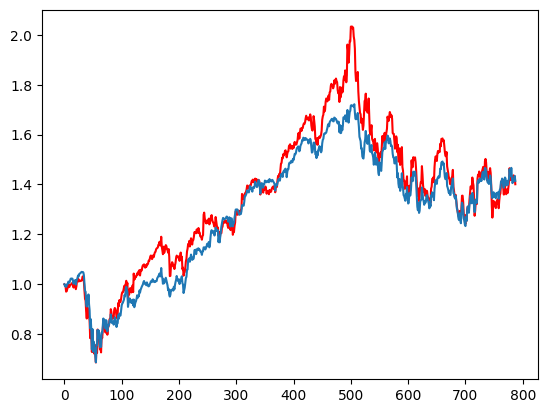

In [200]:
plt.plot(kelly,color='red')
plt.plot(wasser_eps)

In [201]:
portfolio_alloc_wass[eps_vec.index(eps), :]

array([0.11090542, 0.15602441, 0.13302869, 0.11536032, 0.16925436,
       0.0611133 , 0.00315676, 0.18478933, 0.01003093, 0.05633647])

/usr/local/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.save_action_memory to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.save_action_memory` for environment variables or `env.get_wrapper_attr('save_action_memory')` that will search the reminding wrappers.
  logger.warn(


Finished!
           date  account_value
0    2020-01-02  100000.000000
1    2020-01-03   99893.386234
2    2020-01-06   99900.220726
3    2020-01-07   99789.760742
4    2020-01-08   99855.315170
..          ...            ...
783  2023-02-10  104271.250282
784  2023-02-13  104421.030045
785  2023-02-14  104373.221027
786  2023-02-15  104475.314583
787  2023-02-16  104173.819714

[788 rows x 2 columns]
            AAPL  ABBV  ABT  ACN  ADBE  AMZN  AVGO  BAC  BMY  CMCSA  ...  T  \
date                                                                 ...      
2020-01-02     0     1    0   18     0     0     0    0    0      0  ...  0   
2020-01-03     0     0    0    0     0     0     0    0    0      0  ...  0   
2020-01-06     0     0    0    0     0     0     0    0    0      0  ...  0   
2020-01-07     0     0    0    0     0     0     0    0    0      0  ...  0   
2020-01-08     0     0    0    0     0     0     0    0    0      0  ...  0   
...          ...   ...  ...  ...   ...   

/usr/local/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.save_asset_memory to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.save_asset_memory` for environment variables or `env.get_wrapper_attr('save_asset_memory')` that will search the reminding wrappers.
  logger.warn(
/usr/local/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.save_action_memory to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.save_action_memory` for environment variables or `env.get_wrapper_attr('save_action_memory')` that will search the reminding wrappers.
  logger.warn(
/usr/local/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.save_asset_memory to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.save_ass

day: 787, episode: 10
begin_total_asset: 100000.00
end_total_asset: 107816.70
total_reward: 7816.70
total_cost: 0.00
total_trades: 1
Sharpe: 0.368
Finished!
           date  account_value
0    2020-01-02  100000.000000
1    2020-01-03   99967.530731
2    2020-01-06   99840.439240
3    2020-01-07   99422.988434
4    2020-01-08   99460.098328
..          ...            ...
783  2023-02-10  108082.796509
784  2023-02-13  108509.150909
785  2023-02-14  108161.466583
786  2023-02-15  108441.163940
787  2023-02-16  107816.700775

[788 rows x 2 columns]
            AAPL  ABBV  ABT  ACN  ADBE  AMZN  AVGO  BAC  BMY  CMCSA  ...  T  \
date                                                                 ...      
2020-01-02     0     0    0   99     0     0     0    0    0      0  ...  0   
2020-01-03     0     0    0    0     0     0     0    0    0      0  ...  0   
2020-01-06     0     0    0    0     0     0     0    0    0      0  ...  0   
2020-01-07     0     0    0    0     0     0     0  

/usr/local/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.save_asset_memory to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.save_asset_memory` for environment variables or `env.get_wrapper_attr('save_asset_memory')` that will search the reminding wrappers.
  logger.warn(
/usr/local/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.save_action_memory to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.save_action_memory` for environment variables or `env.get_wrapper_attr('save_action_memory')` that will search the reminding wrappers.
  logger.warn(
/usr/local/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.save_asset_memory to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.save_ass

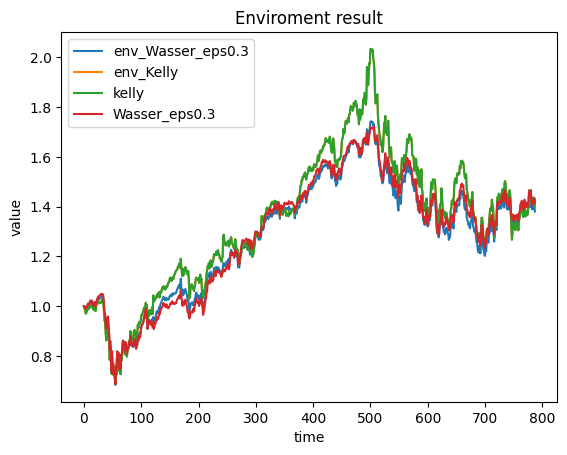

In [202]:
#environment test

#simulation index: m
m=2
env.reset()
action=np.zeros(len(ticker_list))
action[indexs[m]]=portfolio_alloc_wass[eps_vec.index(eps), :]
state, reward,terminated, truncated, info=env.step(action)
ini_wealth=np.array(df_kelly[df_kelly['date'] == '2020-01-02'][ticker_list])@np.array(env.save_action_memory().iloc[0,:])
ini_bank=100000-ini_wealth


for i in range(1, 10000):
  action=np.zeros(len(ticker_list))
  state, reward,terminated, truncated, info=env.step(action)
  if terminated==True:
    print('Finished!')
    break

print(env.save_asset_memory())
print(env.save_action_memory())
print((env.save_asset_memory()['account_value']-ini_bank)/ini_wealth)
value_wasser=np.array((env.save_asset_memory()['account_value']-ini_bank)/ini_wealth)


env.reset()
action=np.zeros(len(ticker_list))
action[indexs[m]]=portfolio_alloc_kelly
state, reward,terminated, truncated, info=env.step(action)
ini_wealth=np.array(df_kelly[df_kelly['date'] == '2020-01-02'][ticker_list])@np.array(env.save_action_memory().iloc[0,:])
ini_bank=100000-ini_wealth
print(f'action:{action},ini_wealth:{ini_wealth},ini_bank:{ini_bank}')


for i in range(1, 10000):
  action=np.zeros(len(ticker_list))
  state, reward,terminated, truncated, info=env.step(action)
  if terminated==True:
    print('Finished!')
    break

print(env.save_asset_memory())
print(env.save_action_memory())
print((env.save_asset_memory()['account_value']-ini_bank)/ini_wealth)
value_kelly=np.array((env.save_asset_memory()['account_value']-ini_bank)/ini_wealth)

plt.plot(value_wasser, label=f'env_Wasser_eps{eps}')
plt.plot(value_kelly, label='env_Kelly')
plt.plot(kelly,label='kelly')
plt.plot(wasser_eps,label=f'Wasser_eps{eps}')
# 添加图例
plt.legend()

# 添加标题和轴标签
plt.title('Enviroment result')
plt.xlabel('time')
plt.ylabel('value')
# 显示图像
plt.show()

In [ ]:
#kelly tend to concenta
print(portfolio_alloc_kelly)

[2.16058439e-08 9.99999963e-01 4.86862163e-10 3.54209539e-10
 2.33526742e-10 2.18303062e-10 2.33743603e-10 1.28270457e-08
 2.45139633e-10 2.78519721e-10]


In [ ]:
env.save_asset_memory().to_csv('array.csv', index=False)

In [ ]:
env.reset()

([1000000,
  6.461977005004883,
  41.20079040527344,
  33.090415954589844,
  43.77754592895508,
  40.190208435058594,
  18.68059730529785,
  16.743507385253906,
  44.53850555419922,
  27.84317398071289,
  135.5762176513672,
  20.428892135620117,
  28.019489288330078,
  76.01286315917969,
  13.605185508728027,
  42.650634765625,
  29.497779846191406,
  18.351234436035156,
  42.26898956298828,
  40.83504104614258,
  21.83247947692871,
  23.389404296875,
  13.76175308227539,
  39.90241241455078,
  35.336143493652344,
  25.497283935546875,
  19.8625545501709,
  15.17166519165039,
  24.284013748168945,
  13.15079402923584,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  6.483364988419307,
  6.4

In [ ]:
env.action_space
observation, info = env.reset()
rewardlist=[]
total_reward=0

action=np.ones(29)*1/29
env.step(action)
action=np.zeros(29)
for i in range(100):
    env.step(action)
    print(env.step(action)[-1],env.step(action)[-2],env.step(action)[-3],env.step(action)[-4],env.save_asset_memory())
#     total_reward += reward
# print(i,env._get_date(),env.save_asset_memory())
    # if terminated or truncated:
    #     observation, info = env.reset()
    #     break
# 关闭环境
# env.close()


{} False False -23.690696239471436          date  account_value
0  2010-01-04   1.000000e+06
1  2010-01-05   1.000001e+06
2  2010-01-06   9.999965e+05
3  2010-01-07   1.000018e+06
4  2010-01-08   1.000015e+06
5  2010-01-11   1.000013e+06
6  2010-01-12   9.999892e+05
{} False False -22.321500778198242           date  account_value
0   2010-01-04   1.000000e+06
1   2010-01-05   1.000001e+06
2   2010-01-06   9.999965e+05
3   2010-01-07   1.000018e+06
4   2010-01-08   1.000015e+06
5   2010-01-11   1.000013e+06
6   2010-01-12   9.999892e+05
7   2010-01-13   1.000007e+06
8   2010-01-14   1.000018e+06
9   2010-01-15   9.999884e+05
10  2010-01-19   1.000025e+06
11  2010-01-20   1.000003e+06
{} False False 22.43556547164917           date  account_value
0   2010-01-04   1.000000e+06
1   2010-01-05   1.000001e+06
2   2010-01-06   9.999965e+05
3   2010-01-07   1.000018e+06
4   2010-01-08   1.000015e+06
5   2010-01-11   1.000013e+06
6   2010-01-12   9.999892e+05
7   2010-01-13   1.000007e+06
8   2

In [ ]:
total_reward

3591190.5097667305

In [ ]:
df.index.unique()

RangeIndex(start=0, stop=97013, step=1)

## Environment for Training



In [ ]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


<a id='5'></a>
# Part 6: Train DRL Agents
* The DRL algorithms are from **Stable Baselines 3**. Users are also encouraged to try **ElegantRL** and **Ray RLlib**.
* FinRL includes fine-tuned standard DRL algorithms, such as DQN, DDPG, Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

In [ ]:
agent = DRLAgent(env = env_train)

if_using_a2c = True
if_using_ddpg = True
if_using_ppo = True
if_using_td3 = True
if_using_sac = True


### Agent Training: 5 algorithms (A2C, DDPG, PPO, TD3, SAC)


### Agent 1: A2C


In [ ]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

if if_using_a2c:
  # set up logger
  tmp_path = RESULTS_DIR + '/a2c'
  new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_a2c.set_logger(new_logger_a2c)


{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device
Logging to results/a2c


In [ ]:
trained_a2c = agent.train_model(model=model_a2c,
                             tb_log_name='a2c',
                             total_timesteps=50000) if if_using_a2c else None

-------------------------------------
| time/                 |           |
|    fps                | 42        |
|    iterations         | 100       |
|    time_elapsed       | 11        |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -41.2     |
|    explained_variance | 5.96e-08  |
|    learning_rate      | 0.0007    |
|    n_updates          | 99        |
|    policy_loss        | -59.6     |
|    reward             | 1.0448978 |
|    std                | 1         |
|    value_loss         | 3.62      |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 51        |
|    iterations         | 200       |
|    time_elapsed       | 19        |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -41.2     |
|    explained_variance | 0.105     |
|    learning_rate      | 0.0007    |
|    n_updat

### Agent 2: DDPG

In [ ]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

if if_using_ddpg:
  # set up logger
  tmp_path = RESULTS_DIR + '/ddpg'
  new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ddpg.set_logger(new_logger_ddpg)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cpu device
Logging to results/ddpg


In [ ]:
trained_ddpg = agent.train_model(model=model_ddpg,
                             tb_log_name='ddpg',
                             total_timesteps=50000) if if_using_ddpg else None

day: 2956, episode: 20
begin_total_asset: 1000000.00
end_total_asset: 5442983.33
total_reward: 4442983.33
total_cost: 1749.20
total_trades: 36503
Sharpe: 0.890
-----------------------------------
| time/              |            |
|    episodes        | 4          |
|    fps             | 24         |
|    time_elapsed    | 491        |
|    total_timesteps | 11828      |
| train/             |            |
|    actor_loss      | 8.32       |
|    critic_loss     | 55.7       |
|    learning_rate   | 0.001      |
|    n_updates       | 8871       |
|    reward          | -7.7807484 |
-----------------------------------
-----------------------------------
| time/              |            |
|    episodes        | 8          |
|    fps             | 21         |
|    time_elapsed    | 1104       |
|    total_timesteps | 23656      |
| train/             |            |
|    actor_loss      | 0.904      |
|    critic_loss     | 4.34       |
|    learning_rate   | 0.001      |
|    n_updat

### Agent 3: PPO

In [ ]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

if if_using_ppo:
  # set up logger
  tmp_path = RESULTS_DIR + '/ppo'
  new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ppo.set_logger(new_logger_ppo)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device
Logging to results/ppo


In [ ]:
trained_ppo = agent.train_model(model=model_ppo,
                             tb_log_name='ppo',
                             total_timesteps=50000) if if_using_ppo else None

----------------------------------
| time/              |           |
|    fps             | 62        |
|    iterations      | 1         |
|    time_elapsed    | 32        |
|    total_timesteps | 2048      |
| train/             |           |
|    reward          | 1.9690489 |
----------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 61          |
|    iterations           | 2           |
|    time_elapsed         | 66          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.014264977 |
|    clip_fraction        | 0.202       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.2       |
|    explained_variance   | -0.0122     |
|    learning_rate        | 0.00025     |
|    loss                 | 6.85        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0308     |
|    reward  

### Agent 4: TD3

In [ ]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100,
              "buffer_size": 1000000,
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

if if_using_td3:
  # set up logger
  tmp_path = RESULTS_DIR + '/td3'
  new_logger_td3 = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_td3.set_logger(new_logger_td3)

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device
Logging to results/td3


In [ ]:
trained_td3 = agent.train_model(model=model_td3,
                             tb_log_name='td3',
                             total_timesteps=50000) if if_using_td3 else None

-----------------------------------
| time/              |            |
|    episodes        | 4          |
|    fps             | 24         |
|    time_elapsed    | 485        |
|    total_timesteps | 11828      |
| train/             |            |
|    actor_loss      | -18.2      |
|    critic_loss     | 3.05e+03   |
|    learning_rate   | 0.001      |
|    n_updates       | 8871       |
|    reward          | -5.4769893 |
-----------------------------------
day: 2956, episode: 60
begin_total_asset: 1000000.00
end_total_asset: 3288091.49
total_reward: 2288091.49
total_cost: 1185.23
total_trades: 59158
Sharpe: 0.619
-----------------------------------
| time/              |            |
|    episodes        | 8          |
|    fps             | 21         |
|    time_elapsed    | 1092       |
|    total_timesteps | 23656      |
| train/             |            |
|    actor_loss      | 9.12       |
|    critic_loss     | 83.9       |
|    learning_rate   | 0.001      |
|    n_updat

### Agent 5: SAC

In [ ]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

if if_using_sac:
  # set up logger
  tmp_path = RESULTS_DIR + '/sac'
  new_logger_sac = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_sac.set_logger(new_logger_sac)

{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cpu device
Logging to results/sac


In [ ]:
trained_sac = agent.train_model(model=model_sac,
                             tb_log_name='sac',
                             total_timesteps=50000) if if_using_sac else None

-----------------------------------
| time/              |            |
|    episodes        | 4          |
|    fps             | 19         |
|    time_elapsed    | 599        |
|    total_timesteps | 11828      |
| train/             |            |
|    actor_loss      | 267        |
|    critic_loss     | 20.6       |
|    ent_coef        | 0.0815     |
|    ent_coef_loss   | -114       |
|    learning_rate   | 0.0001     |
|    n_updates       | 11727      |
|    reward          | -3.5861566 |
-----------------------------------
day: 2956, episode: 80
begin_total_asset: 1000000.00
end_total_asset: 3861827.22
total_reward: 2861827.22
total_cost: 18573.40
total_trades: 51384
Sharpe: 0.753
----------------------------------
| time/              |           |
|    episodes        | 8         |
|    fps             | 19        |
|    time_elapsed    | 1215      |
|    total_timesteps | 23656     |
| train/             |           |
|    actor_loss      | 105       |
|    critic_loss   

## In-sample Performance

Assume that the initial capital is $1,000,000.

### Set turbulence threshold
Set the turbulence threshold to be greater than the maximum of insample turbulence data. If current turbulence index is greater than the threshold, then we assume that the current market is volatile

In [ ]:
data_risk_indicator = processed_full[(processed_full.date<TRAIN_END_DATE) & (processed_full.date>=TRAIN_START_DATE)]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

In [ ]:
insample_risk_indicator.vix.describe()

count    2957.000000
mean       18.105293
std         7.272476
min         9.140000
25%        13.370000
50%        16.209999
75%        20.629999
max        82.690002
Name: vix, dtype: float64

In [ ]:
insample_risk_indicator.vix.quantile(0.996)

57.212001831054636

In [ ]:
insample_risk_indicator.turbulence.describe()

count    2957.000000
mean       34.139586
std        43.879103
min         0.000000
25%        14.613449
50%        23.644963
75%        38.292666
max       652.505968
Name: turbulence, dtype: float64

In [ ]:
insample_risk_indicator.turbulence.quantile(0.996)

291.7261025697854

### Trading (Out-of-sample Performance)

We update periodically in order to take full advantage of the data, e.g., retrain quarterly, monthly or weekly. We also tune the parameters along the way, in this notebook we use the in-sample data from 2009-01 to 2020-07 to tune the parameters once, so there is some alpha decay here as the length of trade date extends.

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [ ]:
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [ ]:
trade.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2021-10-01,AAPL,141.899994,142.919998,139.110001,141.404266,94639600.0,4.0,-1.703487,155.382845,137.132192,46.927735,-142.190143,41.749873,147.171798,146.269416,21.1,120.122917
0,2021-10-01,AMGN,213.589996,214.610001,210.800003,203.845886,2629400.0,4.0,-3.097331,212.767983,199.379593,40.408568,-96.756949,36.189244,208.480831,217.103342,21.1,120.122917
0,2021-10-01,AXP,168.500000,175.119995,168.479996,170.695389,3956000.0,4.0,2.281748,174.864263,149.785746,56.265103,117.565552,15.667511,161.812905,164.064442,21.1,120.122917
0,2021-10-01,BA,222.850006,226.720001,220.600006,226.000000,9113600.0,4.0,0.730320,226.909442,205.727561,51.614047,116.649440,2.027170,217.175334,221.968500,21.1,120.122917
0,2021-10-01,CAT,192.899994,195.869995,191.240005,187.928040,3695500.0,4.0,-3.640323,205.735917,181.432778,41.999441,-112.087750,36.203176,196.993865,200.522105,21.1,120.122917


In [ ]:
trained_moedl = trained_a2c
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=trained_moedl,
    environment = e_trade_gym)

hit end!


In [ ]:
trained_moedl = trained_ddpg
df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
    model=trained_moedl,
    environment = e_trade_gym)

hit end!


In [ ]:
trained_moedl = trained_ppo
df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
    model=trained_moedl,
    environment = e_trade_gym)

hit end!


In [ ]:
trained_moedl = trained_td3
df_account_value_td3, df_actions_td3 = DRLAgent.DRL_prediction(
    model=trained_moedl,
    environment = e_trade_gym)

hit end!


In [ ]:
trained_moedl = trained_sac
df_account_value_sac, df_actions_sac = DRLAgent.DRL_prediction(
    model=trained_moedl,
    environment = e_trade_gym)

hit end!


In [ ]:
df_account_value_a2c.shape

(353, 2)

<a id='7'></a>
# Part 6.5: Mean Variance Optimization

In [ ]:
mvo_df.head()

,date,tic,close
0,2010-01-04,AAPL,6.505280
1,2010-01-04,AMGN,42.888943
2,2010-01-04,AXP,33.675961
3,2010-01-04,BA,43.777538
4,2010-01-04,CAT,41.156910


In [ ]:
fst = mvo_df
fst = fst.iloc[0*29:0*29+29, :]
tic = fst['tic'].tolist()

mvo = pd.DataFrame()

for k in range(len(tic)):
  mvo[tic[k]] = 0

for i in range(mvo_df.shape[0]//29):
  n = mvo_df
  n = n.iloc[i*29:i*29+29, :]
  date = n['date'][i*29]
  mvo.loc[date] = n['close'].tolist()

In [ ]:
mvo.shape[0]

3310

### Helper functions

In [ ]:
from scipy import optimize
from scipy.optimize import linprog

#function obtains maximal return portfolio using linear programming

def MaximizeReturns(MeanReturns, PortfolioSize):

  #dependencies


  c = (np.multiply(-1, MeanReturns))
  A = np.ones([PortfolioSize,1]).T
  b=[1]
  res = linprog(c, A_ub = A, b_ub = b, bounds = (0,1), method = 'simplex')

  return res

def MinimizeRisk(CovarReturns, PortfolioSize):

  def f(x, CovarReturns):
    func = np.matmul(np.matmul(x, CovarReturns), x.T)
    return func

  def constraintEq(x):
    A=np.ones(x.shape)
    b=1
    constraintVal = np.matmul(A,x.T)-b
    return constraintVal

  xinit=np.repeat(0.1, PortfolioSize)
  cons = ({'type': 'eq', 'fun':constraintEq})
  lb = 0
  ub = 1
  bnds = tuple([(lb,ub) for x in xinit])

  opt = optimize.minimize (f, x0 = xinit, args = (CovarReturns),  bounds = bnds, \
                             constraints = cons, tol = 10**-3)

  return opt

def MinimizeRiskConstr(MeanReturns, CovarReturns, PortfolioSize, R):

  def  f(x,CovarReturns):

    func = np.matmul(np.matmul(x,CovarReturns ), x.T)
    return func

  def constraintEq(x):
    AEq=np.ones(x.shape)
    bEq=1
    EqconstraintVal = np.matmul(AEq,x.T)-bEq
    return EqconstraintVal

  def constraintIneq(x, MeanReturns, R):
    AIneq = np.array(MeanReturns)
    bIneq = R
    IneqconstraintVal = np.matmul(AIneq,x.T) - bIneq
    return IneqconstraintVal


  xinit=np.repeat(0.1, PortfolioSize)
  cons = ({'type': 'eq', 'fun':constraintEq},
          {'type':'ineq', 'fun':constraintIneq, 'args':(MeanReturns,R) })
  lb = 0
  ub = 1
  bnds = tuple([(lb,ub) for x in xinit])

  opt = optimize.minimize (f, args = (CovarReturns), method ='trust-constr',  \
                x0 = xinit,   bounds = bnds, constraints = cons, tol = 10**-3)

  return opt

In [ ]:
def StockReturnsComputing(StockPrice, Rows, Columns):
  import numpy as np
  StockReturn = np.zeros([Rows-1, Columns])
  for j in range(Columns):        # j: Assets
    for i in range(Rows-1):     # i: Daily Prices
      StockReturn[i,j]=((StockPrice[i+1, j]-StockPrice[i,j])/StockPrice[i,j])* 100

  return StockReturn

### Calculate mean returns and variance-covariance matrix

In [ ]:
# Obtain optimal portfolio sets that maximize return and minimize risk

#Dependencies
import numpy as np
import pandas as pd


#input k-portfolio 1 dataset comprising 15 stocks
# StockFileName = './DJIA_Apr112014_Apr112019_kpf1.csv'

Rows = 1259  #excluding header
Columns = 15  #excluding date
portfolioSize = 29 #set portfolio size

#read stock prices in a dataframe
# df = pd.read_csv(StockFileName,  nrows= Rows)

#extract asset labels
# assetLabels = df.columns[1:Columns+1].tolist()
# print(assetLabels)

#extract asset prices
# StockData = df.iloc[0:, 1:]
StockData = mvo.head(mvo.shape[0]-336)
TradeData = mvo.tail(336)
# df.head()
TradeData.to_numpy()


array([[148.01602173, 198.85264587, 178.01608276, ...,  49.54628372,
         45.13446426, 145.86064148],
       [147.55015564, 196.85154724, 175.14341736, ...,  49.12624359,
         44.02268982, 144.66435242],
       [151.23765564, 197.41375732, 171.77888489, ...,  49.28492355,
         44.00400162, 145.56646729],
       ...,
       [149.3999939 , 237.61999512, 175.13999939, ...,  38.52999878,
         36.20999908, 142.08999634],
       [146.71000671, 233.66000366, 174.25      , ...,  38.74000168,
         35.79999924, 142.47000122],
       [147.91999817, 234.44999695, 173.30000305, ...,  38.88000107,
         35.38999939, 141.44000244]])

In [ ]:
#compute asset returns
arStockPrices = np.asarray(StockData)
[Rows, Cols]=arStockPrices.shape
arReturns = StockReturnsComputing(arStockPrices, Rows, Cols)


#compute mean returns and variance covariance matrix of returns
meanReturns = np.mean(arReturns, axis = 0)
covReturns = np.cov(arReturns, rowvar=False)

#set precision for printing results
np.set_printoptions(precision=3, suppress = True)

#display mean returns and variance-covariance matrix of returns
print('Mean returns of assets in k-portfolio 1\n', meanReturns)
print('Variance-Covariance matrix of returns\n', covReturns)


Mean returns of assets in k-portfolio 1
 [0.121 0.063 0.073 0.078 0.069 0.118 0.052 0.043 0.073 0.052 0.106 0.078
 0.022 0.057 0.049 0.073 0.04  0.063 0.046 0.05  0.098 0.096 0.046 0.059
 0.109 0.095 0.042 0.035 0.051]
Variance-Covariance matrix of returns
 [[3.128 1.014 1.29  1.521 1.371 1.689 1.375 1.125 1.088 1.374 1.163 1.221
  1.03  1.525 0.692 1.269 0.664 0.816 1.029 0.733 1.576 1.139 0.668 0.86
  1.144 1.338 0.525 0.908 0.635]
 [1.014 2.4   1.072 1.01  1.066 1.211 1.025 0.965 0.937 1.122 0.978 1.029
  0.851 1.153 0.891 1.14  0.641 0.664 0.906 1.072 1.088 0.873 0.724 0.854
  1.146 1.056 0.631 1.025 0.645]
 [1.29  1.072 3.315 2.475 1.907 1.568 1.428 1.922 1.715 2.237 1.376 1.847
  1.343 1.508 0.861 2.37  0.99  1.075 1.375 0.964 1.357 1.418 0.728 1.505
  1.417 1.8   0.748 1.216 0.584]
 [1.521 1.01  2.475 4.962 2.117 1.687 1.511 2.143 1.838 2.201 1.527 2.121
  1.532 1.699 0.905 2.296 1.117 1.195 1.461 0.949 1.437 1.573 0.748 1.604
  1.472 1.716 0.734 1.362 0.603]
 [1.371 1.066 1.907

In [ ]:
from pypfopt.efficient_frontier import EfficientFrontier

ef_mean = EfficientFrontier(meanReturns, covReturns, weight_bounds=(0, 0.5))
raw_weights_mean = ef_mean.max_sharpe()
cleaned_weights_mean = ef_mean.clean_weights()
mvo_weights = np.array([1000000 * cleaned_weights_mean[i] for i in range(29)])
mvo_weights

array([268510.,      0.,      0.,      0.,      0.,  67170.,      0.,
            0.,      0.,      0., 328490.,      0.,      0.,      0.,
            0.,      0.,      0.,      0.,      0.,      0.,      0.,
        80330.,      0.,      0., 249920.,   5570.,      0.,      0.,
            0.])

In [ ]:
StockData.tail(1)

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,GS,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
2021-10-25,147.341995,197.852112,179.354034,212.869995,196.628174,293.920013,53.038136,107.683975,172.009995,399.109955,...,78.373215,303.950775,161.721741,136.581009,156.46492,440.793488,231.263245,49.079575,45.984653,147.145218


In [ ]:
LastPrice = np.array([1/p for p in StockData.tail(1).to_numpy()[0]])
Initial_Portfolio = np.multiply(mvo_weights, LastPrice)
Initial_Portfolio

array([1822.359,    0.   ,    0.   ,    0.   ,    0.   ,  228.532,
          0.   ,    0.   ,    0.   ,    0.   ,  917.405,    0.   ,
          0.   ,    0.   ,    0.   ,    0.   ,    0.   ,    0.   ,
          0.   ,    0.   ,    0.   ,  496.717,    0.   ,    0.   ,
        566.978,   24.085,    0.   ,    0.   ,    0.   ])

In [ ]:
Portfolio_Assets = TradeData @ Initial_Portfolio
MVO_result = pd.DataFrame(Portfolio_Assets, columns=["Mean Var"])
MVO_result

,Mean Var
2021-10-26,1.002272e+06
2021-10-27,1.002461e+06
2021-10-28,1.011236e+06
2021-10-29,1.010909e+06
2021-11-01,1.001450e+06
...,...
2023-02-21,9.195315e+05
2023-02-22,9.194654e+05
2023-02-23,9.249119e+05
2023-02-24,9.120101e+05


<a id='6'></a>
# Part 7: Backtesting Results
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [ ]:
df_result_a2c = df_account_value_a2c.set_index(df_account_value_a2c.columns[0])
df_result_ddpg = df_account_value_ddpg.set_index(df_account_value_ddpg.columns[0])
df_result_td3 = df_account_value_td3.set_index(df_account_value_td3.columns[0])
df_result_ppo = df_account_value_ppo.set_index(df_account_value_ppo.columns[0])
df_result_sac = df_account_value_sac.set_index(df_account_value_sac.columns[0])
df_account_value_a2c.to_csv("df_account_value_a2c.csv")
#baseline stats
print("==============Get Baseline Stats===========")
df_dji_ = get_baseline(
        ticker="^DJI",
        start = TRADE_START_DATE,
        end = TRADE_END_DATE)
stats = backtest_stats(df_dji_, value_col_name = 'close')
df_dji = pd.DataFrame()
df_dji['date'] = df_account_value_a2c['date']
df_dji['account_value'] = df_dji_['close'] / df_dji_['close'][0] * env_kwargs["initial_amount"]
df_dji.to_csv("df_dji.csv")
df_dji = df_dji.set_index(df_dji.columns[0])
df_dji.to_csv("df_dji+.csv")

result = pd.merge(df_result_a2c, df_result_ddpg, left_index=True, right_index=True, suffixes=('_a2c', '_ddpg'))
result = pd.merge(result, df_result_td3, left_index=True, right_index=True, suffixes=('', '_td3'))
result = pd.merge(result, df_result_ppo, left_index=True, right_index=True, suffixes=('', '_ppo'))
result = pd.merge(result, df_result_sac, left_index=True, right_index=True, suffixes=('', '_sac'))
result = pd.merge(result, MVO_result, left_index=True, right_index=True, suffixes=('', '_mvo'))
result = pd.merge(result, df_dji, left_index=True, right_index=True, suffixes=('', '_dji'))
result.columns = ['a2c', 'ddpg', 'td3', 'ppo', 'sac', 'mean var', 'dji']

print("result: ", result)
result.to_csv("result.csv")

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (354, 8)
Annual return         -0.034876
Cumulative returns    -0.048644
Annual volatility      0.181612
Sharpe ratio          -0.105351
Calmar ratio          -0.158953
Stability              0.280983
Max drawdown          -0.219408
Omega ratio            0.982546
Sortino ratio         -0.146974
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.970602
Daily value at risk   -0.022957
dtype: float64
result:                       a2c          ddpg           td3           ppo  \
2021-10-26  1.051812e+06  1.018527e+06  1.056433e+06  1.011904e+06   
2021-10-27  1.043241e+06  1.014168e+06  1.047235e+06  1.009184e+06   
2021-10-28  1.052310e+06  1.022907e+06  1.054719e+06  1.015529e+06   
2021-10-29  1.055662e+06  1.027023e+06  1.057137e+06  1.014713e+06   
2021-11-01  1.057257e+06  1.032846e+06  1.060964e+06  1.018755e+06 

<Figure size 1080x360 with 0 Axes>

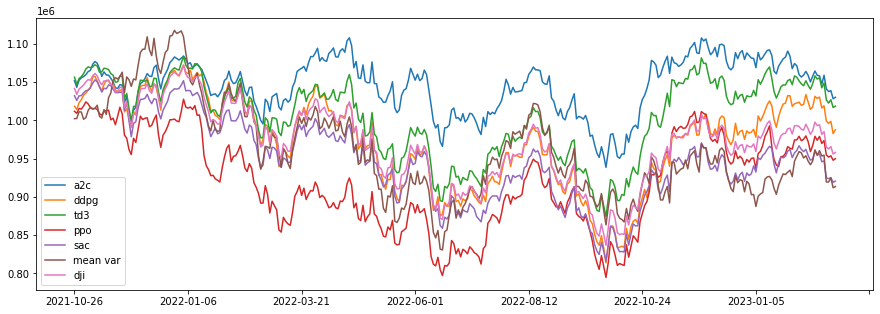

In [ ]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure();
result.plot();